# Regression project task with neural network

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sehriyarmemmedli/turboaz-cars-project")

print("Path to dataset files:", path)

df = pd.read_csv(path + '/cars.csv')

# looking for data size
print(f'shape: {df.shape}')

# dropping duplicates (makes up a significant amount of data)
df.drop_duplicates(subset=['car_rel_url_x'], keep='last', inplace=True)

# looking at data again after duplicate removal
print(f'shape after dropping duplicates on car_rel_url_x column: {df.shape}')

# even after reducing the data size almost 4 times, it is still huge (~150_000 rows)
# to speed up the process, it is favored to work with random sample of data, ~60%
df = df.sample(90_000)

# checking shape again
print(f'last shape: {df.shape}')

100%|██████████| 240M/240M [00:07<00:00, 33.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sehriyarmemmedli/turboaz-cars-project/versions/1
shape: (653721, 56)
shape after dropping duplicates on car_rel_url_x column: (154030, 56)
last shape: (90000, 56)


In [ ]:
# columns to drop :
df.drop(columns=['spare_parts', 'vin', 'featured', 'shop_name', 'barter', 'vip', 'owner_name',\
                 'Yerlərin sayı', 'description', 'engine_displacement_unit',\
    'kilometrage_unit', 'phone', 'car_details_id_x', 'car_rel_url', 'views', 'car_details_id_y',\
                 'id_x', 'currency_x', 'price_x', 'datetime_product',\
    'day', 'hour', 'engine_displacement_num', 'kilometrage_num', 'img_url', 'id_y', 'cars_id', 'car_rel_url_y', 'datetime', 'car_rel_url_x',\
             'datetime_scrape', 'updated', 'Rəng', 'Yeni', 'name', 'attributes', 'Şəhər'], inplace=True
)

# in city column, 'baki', 'gence', 'sumqayit' correspond to ~98% of data. Labeled others with same name,
# so that data shape after preprocessing will drop down, and model predictions will be better because it will learn to generalize,
# given the huge number of data points that belong to same class.
df['city'] = df['city'].apply(lambda x: 'bakı' if x=='bakı' else 'sumqayıt' if x=='sumqayıt' else 'gəncə' if x=='gəncə' else 'rayon')

# 25-30 samples contained sm that belong to bikes, getting rid of that will help our model, model will see only one type of it.
df['Mühərrik'] = df[~(df['Mühərrik'].str.contains('sm'))]['Mühərrik']

# dropping null values in 'Mühərrik' column.
df.dropna(subset=['Mühərrik'], inplace=True)

# feature engineering of 'Mühərrik' column. Data in this column is like : hecm/at_gucu/yanacaq.
# these features need to be extracted.
df['muherrik_hecm'] = df['Mühərrik'].apply(lambda x: x.split('/')[0].split(' ')[0].strip())
df['muherrik_yanacaq'] = df['Mühərrik'].apply(lambda x: x.split('/')[-1].strip())

# Yurus column is numerical(in theory), but in this case it is object type because of string next to it (e.g. 200_000 km)
# feature engineering, splitting and pandas operations, apply, lambda, split, replace to make it numerical type.
df['Yürüş'] = df['Yürüş'].apply(lambda x: x.split(' km')[0].replace(' ', '')).astype(int)


# in 'extra_info' column, representation of different car specific accessories are extracted as individual features.
df['Yüngül lehimli disklər'] = df['extra_info'].apply(lambda x: 'He' if 'Yüngül lehimli disklər' in x.split('* ') else 'Yox')
df['ABS'] = df['extra_info'].apply(lambda x: 'He' if 'ABS' in x.split('* ') else 'Yox')
df['Lyuk'] = df['extra_info'].apply(lambda x: 'He' if 'Lyuk' in x.split('* ') else 'Yox')
df['Yağış sensoru'] = df['extra_info'].apply(lambda x: 'He' if 'Yağış sensoru' in x.split('* ') else 'Yox')
df['Mərkəzi qapanma'] = df['extra_info'].apply(lambda x: 'He' if 'Mərkəzi qapanma' in x.split('* ') else 'Yox')
df['Park radarı'] = df['extra_info'].apply(lambda x: 'He' if 'Park radarı' in x.split('* ') else 'Yox')
df['Kondisioner'] = df['extra_info'].apply(lambda x: 'He' if 'Kondisioner' in x.split('* ') else 'Yox')
df['Oturacaqların isidilməsi'] = df['extra_info'].apply(lambda x: 'He' if 'Oturacaqların isidilməsi' in x.split('* ') else 'Yox')
df['Dəri salon'] = df['extra_info'].apply(lambda x: 'He' if 'Dəri salon' in x.split('* ') else 'Yox')
df['Ksenon lampalar'] = df['extra_info'].apply(lambda x: 'He' if 'Ksenon lampalar' in x.split('* ') else 'Yox')
df['Arxa görüntü kamerası'] = df['extra_info'].apply(lambda x: 'He' if 'Arxa görüntü kamerası' in x.split('* ') else 'Yox')
df['Yan pərdələr'] = df['extra_info'].apply(lambda x: 'He' if 'Yan pərdələr' in x.split('* ') else 'Yox')
df['Oturacaqların ventilyasiyası'] = df['extra_info'].apply(lambda x: 'He' if 'Oturacaqların ventilyasiyası' in x.split('* ') else 'Yox')


# dropping columns after extracting needed features.
if 'extra_info' in df.columns:
  df.drop(columns=['extra_info'], inplace=True)

if 'Mühərrik' in df.columns:
  df.drop(columns=['Mühərrik'], inplace=True)

# not necessary, but makes column readable.
df['Sahiblər'] = df['Sahiblər'].replace('4 və daha çox', '4+')

# currency column has 3 different values: AZN, EUR, USD. Regarding conversions are made.
df['price'] = df[['currency_y', 'price_y']].apply(lambda row:  row['price_y']*1.7 if row['currency_y']=='USD' \
                                                  else row['price_y']*2 if row['currency_y']=='EUR' \
                                                  else row['price_y'], axis=1)

# needed features were extracted, after that, columns are dropped.
df.drop(columns=['price_y', 'currency_y', 'Buraxılış ili'], inplace=True)

# filling NaN values (pandas way)
df.loc[:, 'Qəzalı'].fillna(value='yox', inplace=True)
df.loc[:, 'Sahiblər'].fillna(value='1', inplace=True)
df.loc[:, 'Vəziyyəti'].fillna(value='Vuruğu yoxdur, rənglənməyib', inplace=True)
df.loc[:, 'loan'].fillna(value='yox', inplace=True)
df.loc[:, 'salon'].fillna(value='yox', inplace=True)
df.loc[:, 'Hansı bazar üçün yığılıb'].fillna(value='Rəsmi diler', inplace=True)



# list(df['Ban növü'].value_counts(normalize=True).sort_values(ascending=False).cumsum()[:8].index) --> Which types are mostly distributed(selected ~0.95)
# in below code.

df = df[(df['Ban növü']=='Sedan') | (df['Ban növü']=='Offroader / SUV, 5 qapı')\
| (df['Ban növü']=='Hetçbek, 5 qapı') | (df['Ban növü']=='Universal, 5 qapı')\
| (df['Ban növü']=='Liftbek') | (df['Ban növü']=='Furqon')\
| (df['Ban növü']=='Yük maşını') | (df['Ban növü']=='Minivan')]

# engine volume max can be ~6.5 in liters, but it will be an outlier, below code kind of implements percentile(0.99)
# muherrik_hecm column was object type
df['muherrik_hecm'] = pd.to_numeric(df['muherrik_hecm'])
df = df[df['muherrik_hecm']<6.5]


# Model column has ~1300 different values, Marka ~ 140 (most of them 1-20). One-Hot Encoding them will increase number of dimensions drastically.
# Instead, it would be favorable to choose the occurences that happen at least 51 times for Model column, and 21 times for Marka column,
# given that these counts make up a little amount and bring outliers with them(could affect model negatively).
# Below code does that.

a = df['Model'].value_counts().to_frame()[(df['Model'].value_counts()>50)].index.to_list()
b = df['Model'].apply(lambda x: x if x in a else -1)
df = df[b != (-1)]


a = df['Marka'].value_counts().to_frame()[df['Marka'].value_counts()>20].index.to_list()
b = df['Marka'].apply(lambda x: x if x in a else -1)
df = df[b != (-1)]



<ipython-input-3-59af9f3131fe>:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.loc[:, 'Qəzalı'].fillna(value='yox', inplace=True)
<ipython-input-3-59af9f3131fe>:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [ ]:
X = df.drop('price', axis=1)
y = df['price']

In [ ]:
df.select_dtypes(include=[np.number]).columns

Index(['production_year', 'Yürüş', 'muherrik_hecm', 'price'], dtype='object')

In [ ]:
df.select_dtypes(exclude=[np.number]).columns

Index(['city', 'loan', 'salon', 'Ban növü', 'Hansı bazar üçün yığılıb',
       'Marka', 'Model', 'Qəzalı', 'Sahiblər', 'Sürətlər qutusu', 'Vəziyyəti',
       'Ötürücü', 'muherrik_yanacaq', 'Yüngül lehimli disklər', 'ABS', 'Lyuk',
       'Yağış sensoru', 'Mərkəzi qapanma', 'Park radarı', 'Kondisioner',
       'Oturacaqların isidilməsi', 'Dəri salon', 'Ksenon lampalar',
       'Arxa görüntü kamerası', 'Yan pərdələr',
       'Oturacaqların ventilyasiyası'],
      dtype='object')

In [ ]:
df.iloc[0, :].shape

(30,)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

cat_cols = X.select_dtypes(exclude=[np.number]).columns
num_cols = X.select_dtypes(include=[np.number]).columns


ct = ColumnTransformer(
    [
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)

    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train_transformed = ct.fit_transform(X_train)
X_test_transformed = ct.transform(X_test)


model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = [X_train_transformed.shape[1], ]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, kernel_initializer = 'he_normal'),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Dense(100, kernel_initializer='he_normal'),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Dense(1)
])


model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = ['mse'],
    metrics = ['RootMeanSquaredError']
)

model.fit(X_train_transformed, y_train, epochs=10, validation_data = (X_test_transformed, y_test))

Epoch 1/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - RootMeanSquaredError: 25677.4727 - loss: 674875328.0000 - val_RootMeanSquaredError: 15547.3359 - val_loss: 241719664.0000
Epoch 2/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - RootMeanSquaredError: 13660.1992 - loss: 187181040.0000 - val_RootMeanSquaredError: 11980.0537 - val_loss: 143521680.0000
Epoch 3/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - RootMeanSquaredError: 11415.7549 - loss: 131538888.0000 - val_RootMeanSquaredError: 10053.1133 - val_loss: 101065088.0000
Epoch 4/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - RootMeanSquaredError: 9997.0938 - loss: 100874000.0000 - val_RootMeanSquaredError: 8745.5850 - val_loss: 76485248.0000
Epoch 5/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - RootMeanSquaredError: 8336.8447 - loss: 70035896.0000 - val_RootMeanSquaredError: 7841.0703 - val_loss: 61482384.0000
Epoch 6/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - RootMeanSquaredError: 6851.4614 - loss: 47213996.0000 

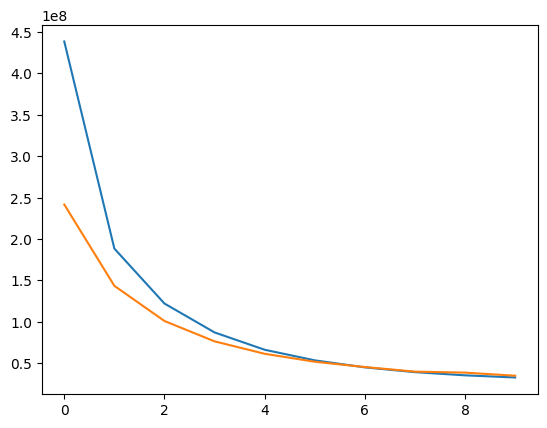

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.show()